In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Set hyperparameters
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 10
learning_rate = 1e-4
epochs = 20

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load your dataset directories
train_dir = '/content/imagenette2/train'  # Replace with your dataset path
val_dir = '/content/imagenette2/val'

# Load training and validation data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


# Load VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

callbacks = [lr_scheduler, early_stopping]

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks
)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 172s 559ms/step - accuracy: 0.2762 - loss: 2.0245 - val_accuracy: 0.7768 - val_loss: 0.7608 - learning_rate: 1.0000e-04
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 195s 541ms/step - accuracy: 0.6492 - loss: 1.0733 - val_accuracy: 0.8410 - val_loss: 0.5077 - learning_rate: 1.0000e-04
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 202s 539ms/step - accuracy: 0.7462 - loss: 0.7838 - val_accuracy: 0.8563 - val_loss: 0.4556 - learning_rate: 1.0000e-04
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 203s 542ms/step - accuracy: 0.8022 - loss: 0.6507 - val_accuracy: 0.8749 - val_loss: 0.3944 - learning_rate: 1.0000e-04
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 163s 541ms/step - accuracy: 0.8082 - loss: 0.6088 - val_accuracy: 0.8831 - val_loss: 0.3594 - learning_rate: 1.0000e-04
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 164s 541ms/step - accuracy: 0.8245 - loss: 0.5485 - val_accuracy: 0.8820 -

In [6]:

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

model.save('/content/model.keras')
print("Model saved successfully!")

123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9219 - loss: 0.2560
Validation Loss: 0.2622
Validation Accuracy: 0.9195
Model saved successfully!


Found 3925 files belonging to 10 classes.
Class names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Accuracy on the randomly selected subset: 90.00%


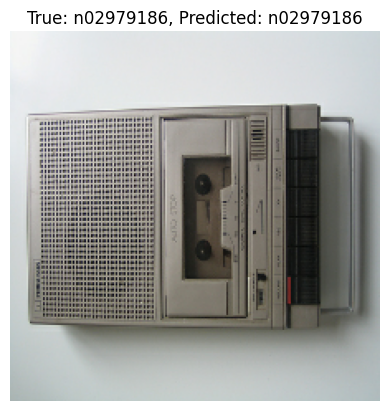

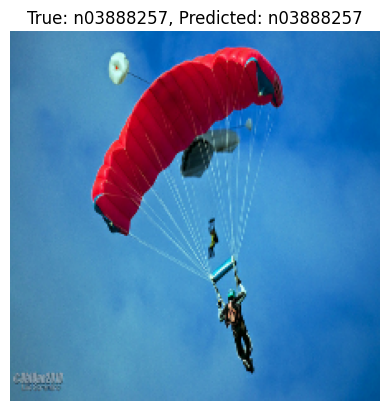

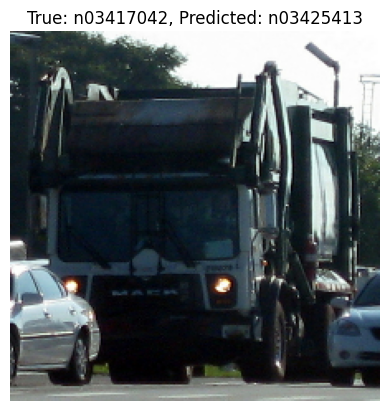

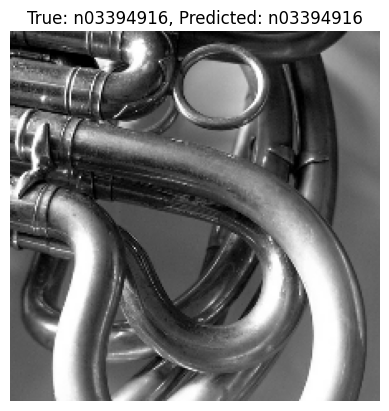

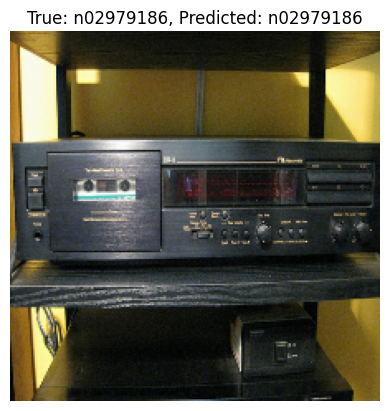

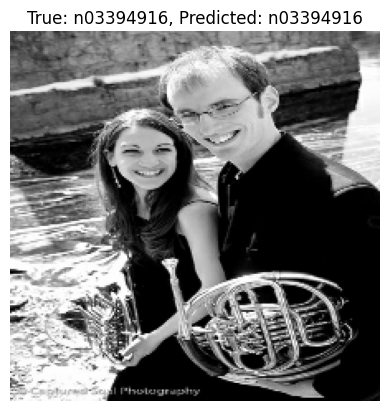

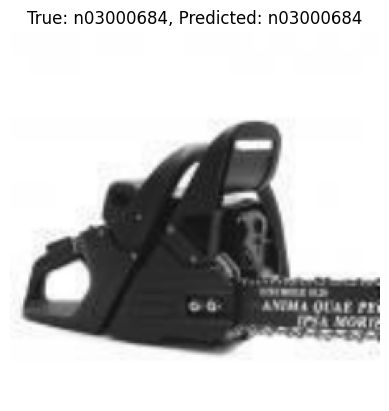

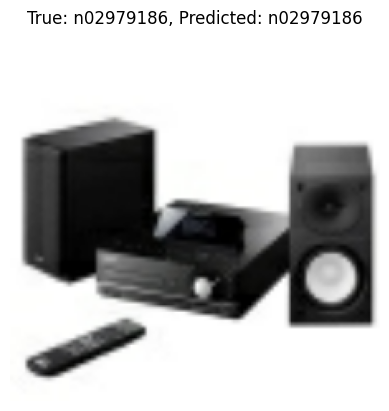

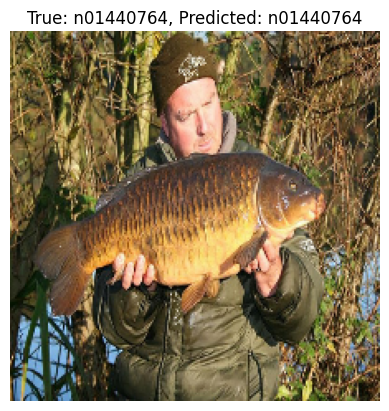

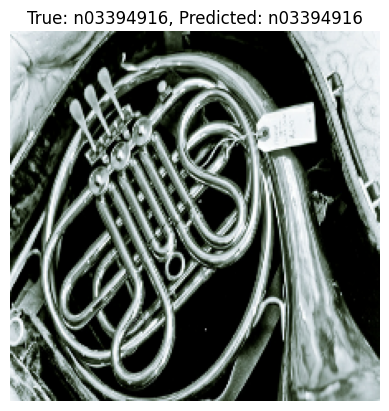

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

# Parameters
data_dir = '/content/imagenette2/val'
img_height = 224
img_width = 224
batch_size = 32
model_path = '/content/model.keras'

# 1. Load Validation Data from Directory
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Get class names from subfolders
class_names = val_dataset.class_names
print(f"Class names: {class_names}")

# Convert dataset to numpy arrays for easy manipulation
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

val_images_full, val_labels_full = dataset_to_numpy(val_dataset)

# 2. Randomly Select 10 Images and Their Labels
def select_random_subset(images, labels, num_samples=10, seed=None):
    np.random.seed(seed)  # Set seed for reproducibility (optional)
    indices = np.random.choice(len(images), size=num_samples, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]
    return selected_images, selected_labels

# Select random images and labels
val_images, val_labels = select_random_subset(val_images_full, val_labels_full, num_samples=10, seed=42)

# 3. Load the Saved Model
model = tf.keras.models.load_model(model_path)

# 4. Predict Using the Model
predictions = model.predict(val_images)  # Get probabilities/logits
predicted_classes = np.argmax(predictions, axis=1)  # Convert to class indices

# 5. Compute Accuracy
accuracy = accuracy_score(val_labels, predicted_classes)
print(f"Accuracy on the randomly selected subset: {accuracy * 100:.2f}%")

# 6. Visualize Results
for i, (img, true_label, pred_label) in enumerate(zip(val_images, val_labels, predicted_classes)):
    plt.imshow(img.astype("uint8"))  # Show the image
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()


In [8]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('/content/model.keras')

# Set up validation data generator
validation_dir = '/content/imagenette2/val'
input_shape = (224, 224)  # Input shape expected by the model
batch_size = 32

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Scale pixel values
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the true labels from the validation set
true_labels = validation_generator.classes

# Generate predictions using the model
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

# Print classification report
report = classification_report(true_labels, predicted_classes, target_names=validation_generator.class_indices.keys())
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", report)


Found 3925 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step
Accuracy: 0.92
Precision: 0.92
F1 Score: 0.92

Classification Report:
               precision    recall  f1-score   support

   n01440764       0.94      0.94      0.94       387
   n02102040       0.98      0.90      0.94       395
   n02979186       0.94      0.91      0.92       357
   n03000684       0.85      0.82      0.83       386
   n03028079       0.92      0.98      0.95       409
   n03394916       0.89      0.94      0.91       394
   n03417042       0.94      0.93      0.93       389
   n03425413       0.88      0.90      0.89       419
   n03445777       0.94      0.94      0.94       399
   n03888257       0.92      0.94      0.93       390

    accuracy                           0.92      3925
   macro avg       0.92      0.92      0.92      3925
weighted avg       0.92      0.92      0.92      3925



In [2]:
import patoolib
patoolib.extract_archive("/content/imagenette2.tgz",outdir="/content")

INFO patool: Extracting /content/imagenette2.tgz ...
INFO:patool:Extracting /content/imagenette2.tgz ...
INFO patool: running /usr/bin/tar --extract --gzip --force-local --file /content/imagenette2.tgz --directory /content
INFO:patool:running /usr/bin/tar --extract --gzip --force-local --file /content/imagenette2.tgz --directory /content
INFO patool: ... /content/imagenette2.tgz extracted to `/content'.
INFO:patool:... /content/imagenette2.tgz extracted to `/content'.


'/content'